In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import graph_overfit

import numpy as np
import pandas as pd
import dill as pkl
import os
import matplotlib.pyplot as plt
import tqdm

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

torch.manual_seed(seed=73)
np.random.seed(seed=73)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
X_train = np.load(os.path.join('data', 'X_train_transformed.npy'), allow_pickle=True)
y_train = np.load(os.path.join('data', 'y_train.pkl'), allow_pickle=True)
X_test = np.load(os.path.join('data', 'X_test_transformed.npy'), allow_pickle=True)
y_test = np.load(os.path.join('data', 'y_test.pkl'), allow_pickle=True)

# features
X_tensor = torch.tensor(X_train.astype(np.float32))
X_test_tensor = torch.tensor(X_test.astype(np.float32))


# happy, angry, relaxed, sad
y_train -= 1
y_tensor = torch.tensor(y_train.values).type(torch.LongTensor)
y_test -= 1
y_test_tensor = torch.tensor(y_test.values).type(torch.LongTensor)

# binary labels
y_train_arousal = np.array(y_train == 0, dtype=float) + np.array(y_train == 1, dtype=float)  # happy + angry, 0: not aroused, 1: aroused
y_train_arousal_tensor = torch.tensor(y_train_arousal).type(torch.float)

y_train_valence = np.array(y_train == 0, dtype=float) + np.array(y_train == 3, dtype=float)  # happy + relaxed, 0: negative, 1: positive
y_train_valence_tensor = torch.tensor(y_train_valence).type(torch.float)

y_test_arousal = np.array(y_test == 0, dtype=float) + np.array(y_test == 1, dtype=float)  # happy + angry, 0: not aroused, 1: aroused
y_test_arousal_tensor = torch.tensor(y_test_arousal).type(torch.float)

y_test_valence = np.array(y_test == 0, dtype=float) + np.array(y_test == 3, dtype=float)  # happy + relaxed, 0: negative, 1: positive
y_test_valence_tensor = torch.tensor(y_test_valence).type(torch.float)

In [ ]:
train_data = TensorDataset(X_tensor, y_tensor, y_train_arousal_tensor, y_train_valence_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor, y_test_arousal_tensor, y_test_valence_tensor)

train_loader = DataLoader(train_data,
                        shuffle=True,
                        batch_size=32,
                        num_workers=0)

test_loader = DataLoader(test_data,
                        shuffle=True,
                        batch_size=16,
                        num_workers=0)

In [ ]:
def custom_cv_folds(fold_ids):
    fold_ids = np.array(fold_ids, dtype=object)
    for n in range(len(fold_ids)):
        all_ids = list(range(len(fold_ids)))
        all_ids.remove(n)
        yield np.concatenate(fold_ids[all_ids]), fold_ids[n]

In [ ]:
def plot_training(train_vals, test_vals):
    fig, axs = plt.subplots(3,1, figsize=(10, 15))
    titles = ['Loss', 'Accuracy', 'Revenue']
    for n, (title, train, test) in enumerate(zip(titles, train_vals, test_vals)):
        axs[n].plot(train, label='train')
        axs[n].plot(test, label='test')
        axs[n].set_title(title)
        axs[n].legend()

    plt.legend()
    plt.show()
    
    return fig

In [ ]:
def calculate_revenue(predictions, targets, test, cost_matrix= torch.tensor([
                                                        [5, -5, -5, 2],
                                                        [-5, 10, 2, -5],
                                                        [-5, 2, 10, -5],
                                                        [2, -5, -2, 5]
                                                        ], device=device)):
    winners = predictions
    max_rev = 11645
    if test == True:
        max_rev = 5060
    return torch.sum(cost_matrix[targets, winners]) / max_rev, torch.sum(cost_matrix[targets, winners])

In [ ]:
class CostSensitiveRegularizedLoss(nn.Module):
    def __init__(self, cost_matrix, lambd, reduction='mean'):
        super(CostSensitiveRegularizedLoss, self).__init__()
        self.cost_matrix = (-1.)*cost_matrix
        self.base_loss = torch.nn.CrossEntropyLoss()
        self.lambd = lambd
        self.reduction = reduction
    
    def forward(self, outputs, labels):
        base_l = self.base_loss(outputs, labels)
        cost_l = (self.cost_matrix[labels]*outputs.float()).sum(dim=-1)
        if self.reduction == 'mean':
            total_l = base_l + self.lambd * cost_l.mean()
        elif self.reduction == 'sum':
            total_l = base_l + self.lambd * cost_l.sum()

        return total_l

In [ ]:
class nn_classifier(nn.Module):
    def __init__(self, n_features=99):
        super(nn_classifier, self).__init__()

        self.input_layer = nn.Linear(n_features, 128)
        self.input_activation = nn.SELU()

        self.hidden_layers1 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.AlphaDropout(p=0.1),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.AlphaDropout(p=0.4),
            nn.Linear(32, 1)
        )

        self.hidden_layers2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.AlphaDropout(p=0.4),
            nn.BatchNorm1d(64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.AlphaDropout(p=0.4),
            nn.Linear(32, 1)
        )

        self.output_layer = nn.Sigmoid()

    def forward(self, x):
        x = self.input_activation(self.input_layer(x))
        x1 = self.hidden_layers1(x)
        x2 = self.hidden_layers2(x)
        output_a = self.output_layer(x1)
        output_v = self.output_layer(x2)
        
        return output_a,output_v

In [ ]:
class BaselineClassifier(nn.Module):
    def __init__(self, y):
        super(BaselineClassifier, self).__init__()
        self.prediction = torch.mode(y)[0]

    def forward(self, x):
        output = torch.zeros((len(x), 4))
        output[:, self.prediction] = 1.
        return output

In [ ]:
def experiment_train(model: nn.Module, data_loader: DataLoader, optimizer: torch.optim.Optimizer, 
                        loss_function: nn.modules.loss, device: torch.device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    revenue = 0
    revenue_p = 0

    for data in data_loader:
        inp, target, binary_target = data[0].to(device), data[1].to(device), (data[2].to(device), data[3].to(device))
        optimizer.zero_grad()
        output_a,output_v = model(inp)

        conf = output_a * output_v
        output_a, output_v = torch.reshape(torch.round(output_a), (-1,)), torch.reshape(torch.round(output_v), (-1,))

        arousal = output_a.clone().detach()
        arousal *= 2
        arousal -= 1
        mask = arousal < 0

        predicted_label = output_v.clone().detach()
        predicted_label[mask] = arousal[mask] * output_v[mask]
        predicted_label[~mask] = arousal[~mask] + output_v[~mask]
        predicted_label -= 2
        predicted_label *= -1

        #loss = loss_function(predicted_label, target, prob)
        loss = loss_function(predicted_label, target, output_a, output_v, binary_target, conf)
        loss.backward()
        optimizer.step()

        running_loss += loss

        winners = predicted_label.clone().detach()
        correct += torch.sum((winners == target))
        total += len(target)
        revs = calculate_revenue(predicted_label.type(torch.long), target, False)
        revenue_p += revs[0]
        revenue += revs[1]

    accuracy = correct.float() / float(total)
    out_loss = running_loss

    return out_loss , accuracy, revenue_p, revenue


def experiment_evaluate(model: nn.Module, data_loader: DataLoader, loss_function: nn.modules.loss, 
                            device: torch.device):
    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        revenue = 0
        revenue_p = 0

        for data in data_loader:
            inp, target, binary_target = data[0].to(device), data[1].to(device), (data[2].to(device), data[3].to(device))
            output_a,output_v = model(inp)

            conf = output_a * output_v
            output_a, output_v = torch.reshape(torch.round(output_a), (-1,)), torch.reshape(torch.round(output_v), (-1,))

            arousal = output_a.clone().detach()
            arousal *= 2
            arousal -= 1
            mask = arousal < 0

            predicted_label = output_v.clone().detach()
            predicted_label[mask] = arousal[mask] * output_v[mask]
            predicted_label[~mask] = arousal[~mask] + output_v[~mask]
            predicted_label -= 2
            predicted_label *= -1

            #loss = loss_function(predicted_label, prob, target)
            loss = loss_function(predicted_label, target, output_a, output_v, binary_target, conf)

            running_loss += loss

            winners = predicted_label.clone().detach()
            correct += torch.sum((winners == target))
            total += len(target)
            revs = calculate_revenue(predicted_label.type(torch.long), target, True)
            revenue_p += revs[0]
            revenue += revs[1]

        accuracy = correct.float() / float(total)
        out_loss = running_loss

    return out_loss, accuracy, revenue_p, revenue

In [ ]:
"""
cost_matrix_np = np.array([
    [5, -5, -5, 2],
    [-5, 10, 2, -5],
    [-5, 2, 10, -5],
    [2, -5, -2, 5]
    ])

cost_matrix = torch.tensor([
        [5, -5, -5, 2],
        [-5, 10, 2, -5],
        [-5, 2, 10, -5],
        [2, -5, -2, 5]
        ], device=device)

scaler = MinMaxScaler()
cost_matrix_transformed = torch.Tensor(scaler.fit_transform(cost_matrix_np))
#cost_matrix_transformed = torch.nn.functional.normalize(torch.Tensor(cost_matrix))
"""

'\ncost_matrix_np = np.array([\n    [5, -5, -5, 2],\n    [-5, 10, 2, -5],\n    [-5, 2, 10, -5],\n    [2, -5, -2, 5]\n    ])\n\ncost_matrix = torch.tensor([\n        [5, -5, -5, 2],\n        [-5, 10, 2, -5],\n        [-5, 2, 10, -5],\n        [2, -5, -2, 5]\n        ], device=device)\n\nscaler = MinMaxScaler()\ncost_matrix_transformed = torch.Tensor(scaler.fit_transform(cost_matrix_np))\n#cost_matrix_transformed = torch.nn.functional.normalize(torch.Tensor(cost_matrix))\n'

In [ ]:
class CostLossSingle(nn.Module):
    """
    Loss function using only the value predicted as most likely --> resulting in integer revenue
    """
    def __init__(self, cost_matrix):
        super(CostLossSingle, self).__init__()
        self.cost_matrix = cost_matrix

    def forward(self, predicted_label, labels, prob):
        loss = torch.sum((self.cost_matrix[labels, predicted_label.type(torch.long)] * prob))
        
        return -loss

In [ ]:
class CostSensitiveRegularizedLoss(nn.Module):
    def __init__(self, cost_matrix, lambd, reduction='mean'):
        super(CostSensitiveRegularizedLoss, self).__init__()
        self.cost_matrix = (-1.)*cost_matrix
        self.base_loss = torch.nn.BCELoss()
        self.lambd = lambd
        self.reduction = reduction
    
    def forward(self, predictions, labels, output_a, output_v, binary_labels, conf):
        base_loss_a = self.base_loss(output_a, binary_labels[0])
        base_loss_v = self.base_loss(output_v, binary_labels[1])
        cost_l = self.cost_matrix[labels, predictions.type(torch.long)]

        if self.reduction == 'mean':
            total_l = base_loss_a + base_loss_v + torch.mean(conf * cost_l)
        elif self.reduction == 'sum':
            total_l = base_loss_a + base_loss_v + torch.sum(conf * cost_l)


        #print(base_loss_a, base_loss_v, total_l)
        return total_l

############# Epoch:0 ###############
Training Loss: 5436.35	Training accuracy: 0.23	Training revenue percentage -0.00	Training revenue -13.00
Test Loss: 3525.24	Test accuracy: 0.23	Test revenue percentage0.05	Test revenue 229.00
############# Epoch:50 ###############
Training Loss: 4505.88	Training accuracy: 0.24	Training revenue percentage 0.01	Training revenue 104.00
Test Loss: 3193.92	Test accuracy: 0.25	Test revenue percentage0.06	Test revenue 302.00
############# Epoch:100 ###############
Training Loss: 4691.53	Training accuracy: 0.23	Training revenue percentage 0.00	Training revenue 53.00
Test Loss: 3410.64	Test accuracy: 0.23	Test revenue percentage0.05	Test revenue 243.00
############# Epoch:150 ###############
Training Loss: 2357.88	Training accuracy: 0.23	Training revenue percentage 0.03	Training revenue 371.00
Test Loss: 3888.47	Test accuracy: 0.22	Test revenue percentage0.03	Test revenue 153.00


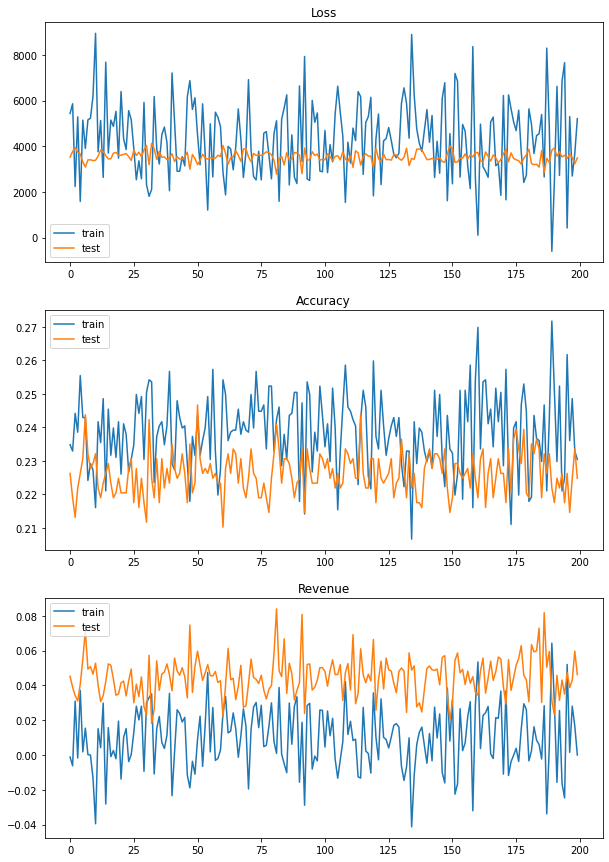

In [ ]:
model = nn_classifier()
baseline_clf = BaselineClassifier(y_tensor)
model.to(device=device)

cost_matrix = torch.tensor([
        [5, -5, -5, 2],
        [-5, 10, 2, -5],
        [-5, 2, 10, -5],
        [2, -5, -2, 5]
        ], dtype=torch.float, device=device)

result_matrix = torch.tensor([
        [2, 3],
        [1, 0]
        ])

#loss_function = CostLoss(cost_matrix)
loss_function = CostLossSingle(cost_matrix)
loss_function = CostSensitiveRegularizedLoss(cost_matrix, 2, 'sum')  # (-1.)*
#loss_function = nn.CrossEntropyLoss()
#loss_function = nn.BCEWithLogitsLoss(requires_grad=True)
lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 200
train_losses, train_accs, train_revs = [], [], []
test_losses, test_accs, test_revs = [], [], []
base_losses, base_accs, base_revs = [], [], []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-8, factor=0.1, patience=2)


for update in range(epochs):
    train_loss, train_acc, train_rev, train_rev_abs  = experiment_train(model, train_loader, optimizer, loss_function, device)
    train_losses.append(train_loss.detach())
    train_accs.append(train_acc.detach())
    train_revs.append(train_rev.detach())

    test_loss, test_acc, test_rev,test_rev_abs = experiment_evaluate(model, test_loader, loss_function, device)
    test_losses.append(test_loss.detach())
    test_accs.append(test_acc.detach())
    test_revs.append(test_rev.detach())
    
    scheduler.step(test_loss)

    #baseline_loss, baseline_acc, baseline_rev = experiment_evaluate(baseline_clf, test_loader_arousal, loss_function, device)
    #base_losses.append(baseline_loss)
    #base_accs.append(baseline_acc)
    #base_revs.append(baseline_rev)

    if update % 50 == 0:
        print(f'############# Epoch:{update} ###############')
        print(f'Training Loss: {train_loss:.2f}\tTraining accuracy: {train_acc:.2f}\tTraining revenue percentage {train_rev:.2f}\tTraining revenue {train_rev_abs:.2f}')
        print(f'Test Loss: {test_loss:.2f}\tTest accuracy: {test_acc:.2f}\tTest revenue percentage{test_rev:.2f}\tTest revenue {test_rev_abs:.2f}')
    
plot = plot_training((train_losses, train_accs, train_revs), (test_losses, test_accs, test_revs))

In [ ]:
plot.savefig(os.path.join('figures', 'experiment2_performance'))

In [ ]:
test_rev_abs

tensor(234)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e2905743-bdaf-45dd-a896-9824e6125426' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>